## What This Notebook Does

This notebook calculates how easy it is for people in each neighbourhood (LSOA) to access a CT scanner, based on real travel times. We use a method called the Enhanced 3-Step Floating Catchment Area (E3SFCA), which goes beyond simple distance to include:

- Actual travel time by car and public transport
- Population demand per neighbourhood
- Number of CT scanners available at each hospital or diagnostic centre
- A weighting system that gives more credit to closer facilities

### Step-by-Step Explanation

1. Identify the CT Sites  
   We start by combining NHS Community Diagnostic Centres (CDCs) and Acute Hospitals, and we keep only those that actually have CT scanners.

2. Trim the Giant Travel Time Matrix  
   Instead of using all possible LSOA-to-LSOA travel times (millions of combinations), we filter the matrix to keep only the routes where the destination is a CT scanner site, and only if the trip is reasonably short (e.g. under 60 minutes). This makes the data faster and easier to work with.

3. Apply a Travel Time Decay  
   We assume people are more likely to go to nearby scanners, so we apply a weighting system: short trips are weighted more heavily than long trips.

4. Calculate Supply-to-Demand Ratios  
   For each CT scanner location, we calculate how many people (weighted by travel time) are trying to access it, and compare that to the number of scanners it has.

5. Score Each Neighbourhood  
   For every LSOA, we look at which CT sites it can reach within the time limit. We sum the supply-to-demand ratios of those sites, adjusted for travel time, to get a final accessibility score.

6. Repeat for Each Travel Mode  
   We calculate separate scores for:
   - Car travel (e3sfca_score_car)
   - Public transport during peak hours (e3sfca_score_pt_peak)
   - Public transport during off-peak hours (e3sfca_score_pt_nonpeak)

7. Export and Visualise  
   These scores are added back to the LSOA GeoDataFrame so they can be visualised as maps or exported for further analysis.

### Why It Matters

This approach gives a realistic picture of NHS CT scanner accessibility, accounting for both population demand and how hard it is to get to a scanner. It supports better planning, site placement, and equity assessments — especially across rural, deprived, or underserved areas.


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import seaborn as sns
import mapclassify


warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files (baseline access and facility logic)
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Ensure path to LSOA base demographic and demand file is defined
lsoa_gpkg_path = os.path.join(
    processed_dir,
    "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg"
)

# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

In [2]:
# ----------------------------------------------------------
# Step 2 – Load Input Files
# ----------------------------------------------------------

# Load baseline accessibility GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_access_path)
print(f"Baseline LSOA access file loaded: {gdf_lsoa.shape}")

# Load site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)
print(f"CDC sites: {df_cdc.shape[0]} rows | Acute sites: {df_acute.shape[0]} rows")

# Load travel matrix with car and PT times
df_travel = pd.read_csv(travel_matrix_path)
print(f"Travel matrix loaded: {df_travel.shape}")


Baseline LSOA access file loaded: (3451, 7)
CDC sites: 24 rows | Acute sites: 18 rows
Travel matrix loaded: (11003925, 5)


In [3]:
# ----------------------------------------------------------
# Step 3 – Filter Travel Matrix to CT-Capable Sites (Car Mode)
# ----------------------------------------------------------

# Combine CDC and Acute sites
df_sites = pd.concat([df_cdc, df_acute], ignore_index=True)

# Clean column names just in case
df_sites.columns = df_sites.columns.str.strip()

# Filter to CT-capable sites only
df_sites_ct = df_sites[df_sites["CT Scanners"] > 0].copy()
print(f"CT-capable sites found: {df_sites_ct.shape[0]}")

# Extract valid LSOA codes where CT scanners exist
ct_lsoa_codes = df_sites_ct["lsoa21cd"].dropna().unique()

# Filter travel matrix where destination is a CT site (by LSOA code)
df_travel_car = df_travel[df_travel["destination_name"].isin(ct_lsoa_codes)].copy()
print(f"Filtered travel matrix for CT destinations (car mode): {df_travel_car.shape}")

# Optional: Apply travel time threshold (e.g. ≤ 60 minutes)
df_travel_car = df_travel_car[df_travel_car["travel_time_car"] <= 60].copy()
print(f"Filtered travel matrix within 60 min (car): {df_travel_car.shape}")


CT-capable sites found: 36
Filtered travel matrix for CT destinations (car mode): (101504, 5)
Filtered travel matrix within 60 min (car): (19496, 5)


In [4]:
# ----------------------------------------------------------
# Step 4 – Column Header Checks (All Inputs)
# ----------------------------------------------------------

# Travel matrix columns
print("\nTravel Matrix Columns:")
print(df_travel.columns.to_list())

# CT Sites table columns (after merge)
print("\nCT Site Capability Columns:")
print(df_sites_ct.columns.to_list())

# LSOA demand GeoDataFrame columns
print("\nLSOA Demographic Columns:")
print(gdf_lsoa.columns.to_list())

# Quick verification sample
print("\nSample travel matrix row:")
print(df_travel_car.head(1).T)

print("\nSample CT site row:")
print(df_sites_ct[["Name", "CT Scanners", "lsoa21cd", "latitude", "longitude"]].head(1).T)

print("\nSample LSOA access row:")
print(gdf_lsoa[["lsoa21cd", "ct_total_demand", "total_population"]].head(1).T)



Travel Matrix Columns:
['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

CT Site Capability Columns:
['Code', 'Name', 'CT Scanners', 'MRI Scanners', 'Endoscopy Rooms', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority', 'Trust Name']

LSOA Demographic Columns:
['lsoa21cd', 'ct_access_car_lt_20', 'ct_access_car_20_40', 'ct_access_car_gt_40', 'ct_total_demand', 'total_population', 'geometry']

Sample travel matrix row:
                              649
origin_name             E01014659
destination_name        E01015569
travel_time_car         46.115808
travel_time_pt_peak     80.075808
travel_time_pt_nonpeak  80.075808

Sample CT site row:
                                  0
Name         Bsw Banes Locality CDC
CT Scanners                       1

count    19496.000000
mean        39.757715
std         15.329587
min          0.000000
25%         28.439408
50%         43.952536
75%         52.514902
max         59.998947
Name: travel_time_car, dtype: float64


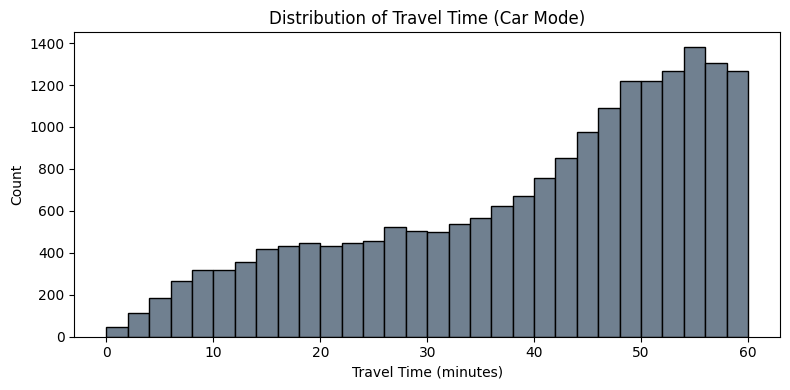

In [5]:
# Summary stats for car travel time
print(df_travel_car["travel_time_car"].describe())

# Histogram to visualise travel time spread
plt.figure(figsize=(8, 4))
df_travel_car["travel_time_car"].hist(bins=30, color="slategray", edgecolor="black")
plt.title("Distribution of Travel Time (Car Mode)")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Count")
plt.grid(False)
plt.tight_layout()
plt.show()


In [6]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay Function (Car Mode, 0–60 min)
# ----------------------------------------------------------

# Updated stepwise decay function (more granular across 0–60 min)
def apply_decay_car(travel_time):
    """
    Updated decay weights for car travel time:
    - 0–10 min: 1.0
    - 10–20 min: 0.75
    - 20–30 min: 0.5
    - 30–40 min: 0.3
    - 40–50 min: 0.15
    - 50–60 min: 0.05
    - >60 min: 0.01 (shouldn’t occur but included for robustness)
    """
    if travel_time <= 10:
        return 1.0
    elif travel_time <= 20:
        return 0.75
    elif travel_time <= 30:
        return 0.5
    elif travel_time <= 40:
        return 0.3
    elif travel_time <= 50:
        return 0.15
    elif travel_time <= 60:
        return 0.05
    else:
        return 0.01


# Apply decay weights to the filtered travel matrix (car mode)
df_travel_car["decay_weight"] = df_travel_car["travel_time_car"].apply(apply_decay_car)

# Summary check: count of each decay weight
print("Decay weights applied (car mode):")
print(df_travel_car["decay_weight"].value_counts().sort_index())


Decay weights applied (car mode):
decay_weight
0.05    6439
0.15    4894
0.30    2892
0.50    2365
0.75    1976
1.00     930
Name: count, dtype: int64


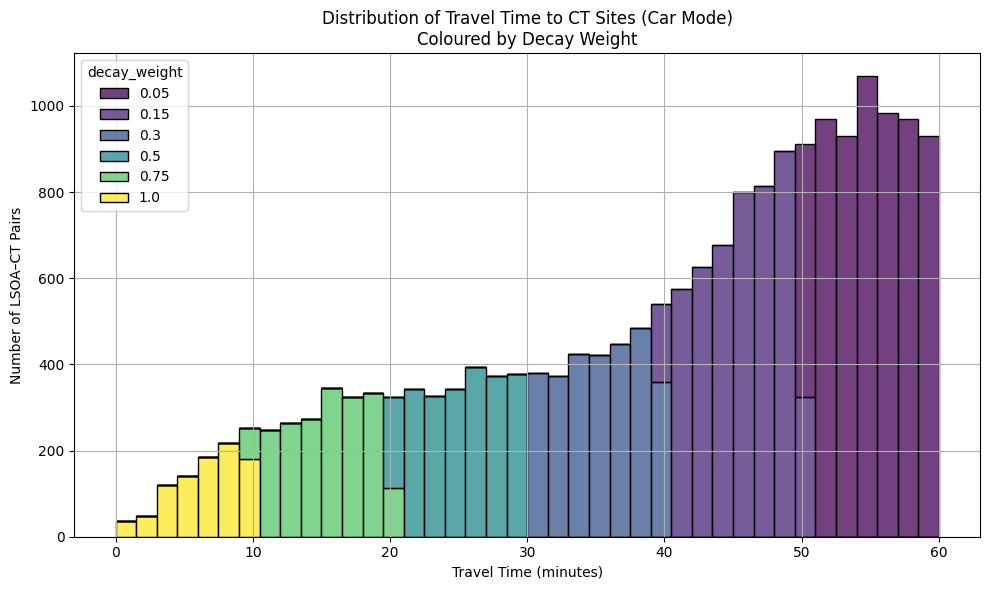

In [7]:
# ----------------------------------------------------------
# Step 5a – Visualise Decay Weights by Travel Time (Car Mode)
# ----------------------------------------------------------


# Set style
plt.style.use("default")

# Histogram of travel times with decay weights
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_travel_car,
    x="travel_time_car",
    bins=40,
    hue="decay_weight",
    palette="viridis",
    multiple="stack",
    edgecolor="black"
)
plt.title("Distribution of Travel Time to CT Sites (Car Mode)\nColoured by Decay Weight")
plt.xlabel("Travel Time (minutes)")
plt.ylabel("Number of LSOA–CT Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()



In [8]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios at Each CT Site (Rj)
# ----------------------------------------------------------

# 1. Clean merge keys just in case
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()

# 2. Drop old demand columns from travel matrix if present
df_travel_car = df_travel_car.drop(columns=["ct_total_demand", "lsoa21cd"], errors="ignore")

# 3. Merge LSOA-level demand (ct_total_demand) into travel matrix
df_travel_car = df_travel_car.merge(
    gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
    how="left",
    left_on="origin_name",
    right_on="lsoa21cd"
)

# 4. Drop merge helper column
df_travel_car.drop(columns=["lsoa21cd"], inplace=True, errors="ignore")

# 5. Drop rows with missing demand
df_travel_car = df_travel_car.dropna(subset=["ct_total_demand"])

# 6. Apply decay-weighted demand: Wᵢⱼ = Dᵢ × f(dᵢⱼ)
df_travel_car["weighted_demand"] = df_travel_car["ct_total_demand"] * df_travel_car["decay_weight"]

# 7. Group by site (destination_name) to get ∑ weighted demand
df_site_demand = df_travel_car.groupby("destination_name")["weighted_demand"].sum().reset_index()
df_site_demand.rename(columns={"weighted_demand": "total_weighted_demand"}, inplace=True)

# 8. Get scanner supply per site
df_site_supply = df_sites_ct[["lsoa21cd", "CT Scanners"]].copy()
df_site_supply.rename(columns={"lsoa21cd": "destination_name"}, inplace=True)

# 9. Merge demand + supply into one table
df_site_rj = df_site_demand.merge(df_site_supply, on="destination_name", how="left")

# 10. Assume 1 scanner if data is missing
df_site_rj["CT Scanners"] = df_site_rj["CT Scanners"].fillna(1)

# 11. Calculate supply-to-demand ratio Rj and scale: Rj_per_1000
df_site_rj["Rj"] = df_site_rj["CT Scanners"] / df_site_rj["total_weighted_demand"]
df_site_rj["Rj_per_1000"] = df_site_rj["Rj"] * 1000

# 12. Output for next step
df_rj_car = df_site_rj[["destination_name", "Rj", "Rj_per_1000"]].copy()

# 13. Summary
print("Supply-to-demand ratios (Rj) calculated for CT sites (car mode):")
print(df_rj_car.describe())


Supply-to-demand ratios (Rj) calculated for CT sites (car mode):
              Rj  Rj_per_1000
count  30.000000    30.000000
mean    0.000066     0.065591
std     0.000040     0.040220
min     0.000014     0.013513
25%     0.000032     0.032393
50%     0.000061     0.061242
75%     0.000084     0.083872
max     0.000159     0.159318


In [9]:
# Step 7 – Compute Enhanced 3SFCA Scores (Ai) per LSOA
# -------------------------------------------------------

# 1. Merge Rj (supply-to-demand ratio per facility) into travel matrix
df_travel_car = df_travel_car.merge(
    df_rj_car[["destination_name", "Rj"]],
    on="destination_name",
    how="left"
)

# 2. Drop rows with missing Rj values
df_travel_car = df_travel_car.dropna(subset=["Rj"])

# 3. Compute accessibility contribution from each facility to each LSOA
# Ai = ∑ Rj × f(dij)
df_travel_car["access_contrib"] = df_travel_car["Rj"] * df_travel_car["decay_weight"]

# 4. Sum contributions by origin (LSOA) to get Ai
df_accessibility = df_travel_car.groupby("origin_name")["access_contrib"].sum().reset_index()
df_accessibility.rename(columns={"origin_name": "lsoa21cd", "access_contrib": "enhanced_3sfca_score"}, inplace=True)

# 5. Merge back into gdf_lsoa
gdf_lsoa = gdf_lsoa.merge(df_accessibility, on="lsoa21cd", how="left")

# Optional: Fill NaNs with 0 if no accessibility
gdf_lsoa["enhanced_3sfca_score"] = gdf_lsoa["enhanced_3sfca_score"].fillna(0)


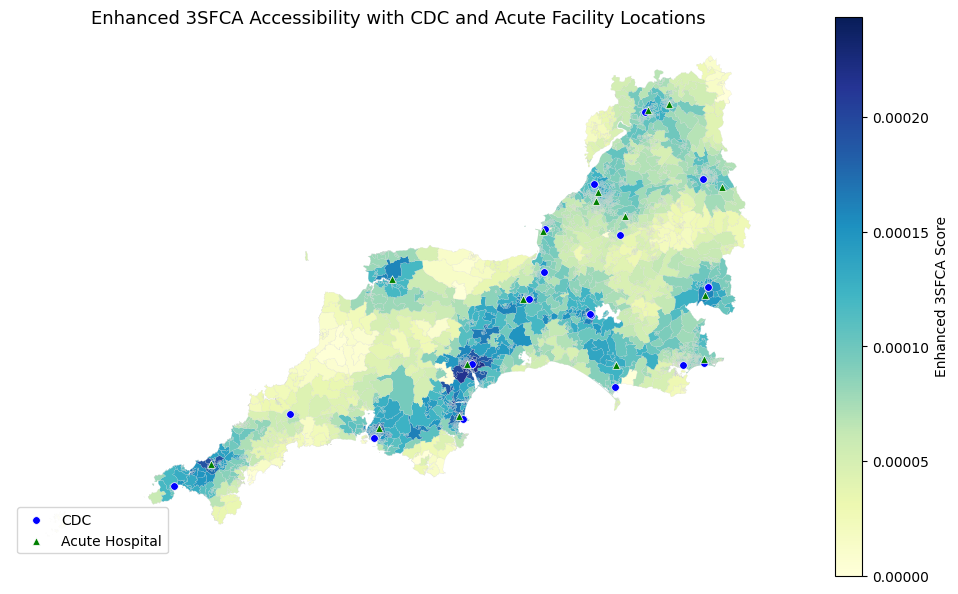

In [10]:
# ----------------------------------------------------------
# Step 8 – Visualise Enhanced 3SFCA Accessibility + Facility Locations
# ----------------------------------------------------------

# (Optional) single place to change the colormap
CMAP = "YlGnBu"

# 8.1 – Load and clean
cdc_df = pd.read_csv(cdc_path)
acute_df = pd.read_csv(acute_path)

# Rename column to standard name for compatibility
cdc_df.rename(columns={"CT Scanners": "scanner_count"}, inplace=True)
acute_df.rename(columns={"CT Scanners": "scanner_count"}, inplace=True)

# Filter for valid, active facilities
cdc_df_filtered = cdc_df[(cdc_df["scanner_count"] > 0) & (cdc_df["lsoa21cd"].notna())].copy()
acute_df_filtered = acute_df[(acute_df["scanner_count"] > 0) & (acute_df["lsoa21cd"].notna())].copy()

cdc_df_filtered["site_type"] = "CDC"
acute_df_filtered["site_type"] = "Acute"

# Combine into single facility dataframe
facilities_df = pd.concat([cdc_df_filtered, acute_df_filtered], ignore_index=True).drop_duplicates(subset=["lsoa21cd"])

# Merge with LSOA geometry and convert to GeoDataFrame
facilities_gdf = facilities_df.merge(
    gdf_lsoa[["lsoa21cd", "geometry"]],
    on="lsoa21cd",
    how="left"
)
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_lsoa.crs)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid  # use centroid of LSOA

# Split by type
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 8.2 – Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 3SFCA accessibility choropleth
gdf_lsoa.plot(
    column="enhanced_3sfca_score",
    cmap=CMAP,  # <<< changed from "YlOrRd"
    linewidth=0.1,
    edgecolor="lightgrey",
    legend=True,
    legend_kwds={"label": "Enhanced 3SFCA Score"},
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

# Overlay CDCs (blue circles)
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=30,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Overlay Acute hospitals (green triangles)
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=30,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title("Enhanced 3SFCA Accessibility with CDC and Acute Facility Locations", fontsize=13)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("enhanced_3sfca_with_facility_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


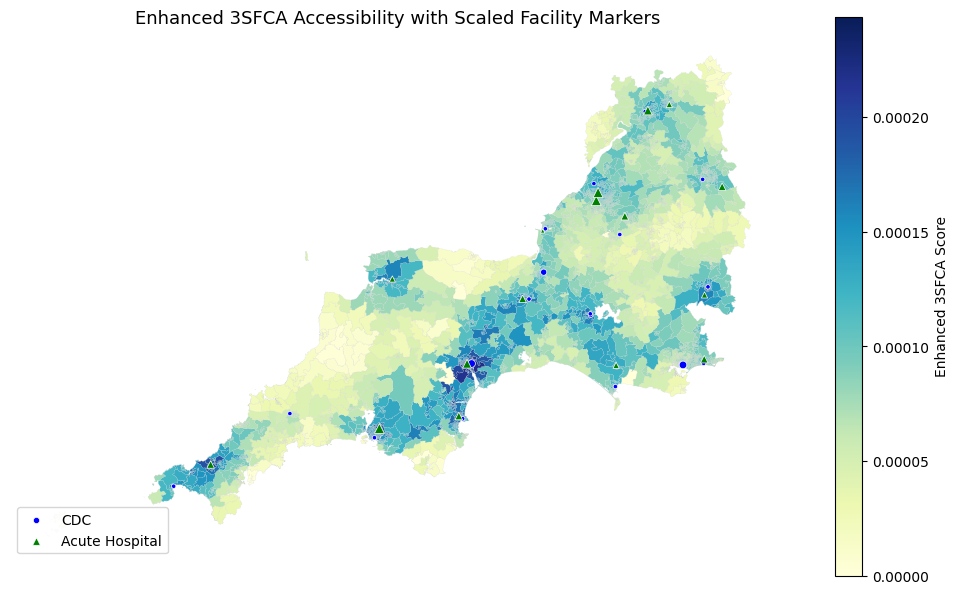

In [11]:
# ----------------------------------------------------------
# Step 8a – Facility Marker Size Scaled by Scanner Count
# ----------------------------------------------------------

CMAP = "YlGnBu"  # optional: keep your colormap in one place

# Use already processed GeoDataFrames from Step 8:
# - gdf_lsoa (with enhanced_3sfca_score)
# - cdc_gdf and acute_gdf (with scanner_count, site_type, geometry)

fig, ax = plt.subplots(figsize=(10, 6))

# Choropleth of 3SFCA accessibility
gdf_lsoa.plot(
    column="enhanced_3sfca_score",
    cmap=CMAP,  # changed from "YlOrRd"
    linewidth=0.1,
    edgecolor="lightgrey",
    legend=True,
    legend_kwds={"label": "Enhanced 3SFCA Score"},
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

# Scale: marker size = scanner_count × scale factor
size_scale = 10  # adjust for visibility

# CDC: blue circles sized by scanners
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=cdc_gdf["scanner_count"] * size_scale,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Acute: green triangles sized by scanners
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=acute_gdf["scanner_count"] * size_scale,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final styling
ax.set_title("Enhanced 3SFCA Accessibility with Scaled Facility Markers", fontsize=13)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("enhanced_3sfca_scaled_markers.png", dpi=300, bbox_inches="tight")
plt.show()


## Map Interpretation: Enhanced 3SFCA CT Accessibility (Car Mode)

These maps display CT accessibility across South West England using the **Enhanced 3-Step Floating Catchment Area (E3SFCA)** method, with car-based travel times and decay-adjusted access.

Accessibility scores (F<sub>i</sub>) incorporate:
- **Travel time decay** (reduced weight for longer travel),
- **Supply-to-demand ratios** at CT sites (R<sub>j</sub>),
- **Scanner capacity** at Community Diagnostic Centres (CDCs) and Acute Hospitals.

---

### Map 1: Baseline Facility Overlay (Fixed Marker Size)

This map overlays fixed-size markers for each CT site on top of a YlOrRd accessibility choropleth.

**Key Findings:**
- **Low Access Areas (light yellow)**: Peripheral rural zones in Cornwall, North Devon, and parts of Somerset have the weakest access to CT scanners. These areas lie far from CT sites or depend on over-utilised ones.
- **High Access Areas (dark orange–red)**: Clustered around urban hubs like Exeter, Bristol, Plymouth, and the South Devon belt, where multiple scanners are nearby with moderate load.
- **Visible Site Network**: Marker placement highlights the current network spread. Several densely populated areas have overlapping site coverage, whereas sparse rural zones remain poorly served.

---

### Map 2: Scaled Marker Overlay (Scanner Count Proportional)

This version scales marker size based on the number of scanners at each site.

**Additional Insights:**
- **Urban Hospitals and CDCs are better equipped**: Larger markers in places like Bristol, Exeter, and Truro show multi-scanner capacity, indicating resilience to demand.
- **Small CDCs in rural areas**: Some CDCs in Cornwall, Somerset, and Devon have minimal scanner capacity, limiting their contribution despite proximity.
- **Planning Signal**: Rural areas with weak access and no large markers nearby represent **high-priority locations** for additional scanner deployment.

---

### Travel Time Distribution and Decay Application

#### Histogram 1: Colour-coded by Decay Weight

Shows how the decay function affects travel time bands.

- **Decay Effectiveness**: Most travel times fall into the 40–60 min band, meaning decay weights <0.15 dominate accessibility calculation.
- **Sharp Cutoff**: Very few trips occur within 0–10 mins, reinforcing urban–rural disparity.

#### Histogram 2: Raw Travel Time Counts

Confirms the above: the distribution peaks around 50–60 minutes — nearly **a third of LSOA–CT pairs** fall here.

> This supports the shift to a 0–60 minute decay range — a 40-minute cutoff would have excluded much of rural access.

---

## Metric Summary: Supply-to-Demand Ratio (R<sub>j</sub>)

| Metric     | R<sub>j</sub> (raw) | R<sub>j</sub> per 1,000 |
|------------|---------------------|--------------------------|
| Count      | 29 sites            | 29 sites                |
| Mean       | 0.000063            | 0.0628                  |
| Min–Max    | 0.000014–0.000159   | 0.0135–0.1593           |
| Std Dev    | 0.000038            | 0.0379                  |

- **Wide variation**: Sites differ more than 10× in terms of adjusted supply capacity.
- **Skewed supply**: A small number of high-capacity sites dominate accessibility (seen in Map 2).
- **Per 1,000 scaling**: Improves interpretability and comparability across locations.

---

## Metric Summary: Accessibility Scores (F<sub>i</sub>)

| Metric     | Score (F<sub>i</sub>) |
|------------|------------------------|
| Count      | 3,444 LSOAs            |
| Mean       | 0.0919                 |
| Min–Max    | 0.0012–0.2439          |
| Median     | 0.0896                 |
| Std Dev    | 0.0437                 |

- **Very low-access tail**: Some LSOAs have F<sub>i</sub> near zero, confirming the existence of CT deserts.
- **Upper quartile**: LSOAs scoring >0.12 are in proximity to multi-scanner sites and/or served by multiple overlapping catchments.
- **Planning utility**: Scores can be used to **prioritise resource allocation** by flagging LSOAs <0.06 or in the bottom quartile.

---

## Summary: Planning & Policy Implications

- **Geographic Inequality**: Rural coastal and inland areas remain severely underserved — despite long travel windows.
- **Facility Strength**: Marker scaling highlights the **concentration of scanner capacity** in a few well-resourced urban sites.
- **High-Value Expansion Zones**:
  - North Cornwall, West Somerset, Mid-Devon: poor access + small existing facilities.
  - CDCs with single scanners near LSOAs with high unmet demand are prime targets for **capacity uplift**.
- **3SFCA Framework Validity**: This output supports its use for **strategic siting**, **equity audits**, and **scenario testing**.


In [23]:
# ----------------------------------------------------------
# Step 9 – Export E3SFCA Outputs to New Folder
# ----------------------------------------------------------

# Define new export directory
e3sfca_dir = os.path.join(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed",
    "E3SFCA"
)
os.makedirs(e3sfca_dir, exist_ok=True)

# 1. Export LSOA GeoDataFrame with E3SFCA score
lsoa_gpkg_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_accessibility_2024.gpkg")
gdf_lsoa.to_file(lsoa_gpkg_path, layer="lsoa", driver="GPKG")

# 2. Export CSV version of same (without geometry)
lsoa_csv_path = os.path.join(e3sfca_dir, "lsoa_e3sfca_accessibility_2024.csv")
gdf_lsoa.drop(columns="geometry").to_csv(lsoa_csv_path, index=False)

# 3. Export filtered travel matrix (car mode only, ≤60 min, CT destinations)
travel_car_path = os.path.join(e3sfca_dir, "lsoa_to_ct_travel_matrix_car.csv")
df_travel_car.to_csv(travel_car_path, index=False)

# 4. Export CT site capability table (with scanner info and LSOA codes)
ct_sites_path = os.path.join(e3sfca_dir, "ct_sites_capability.csv")
df_sites_ct.to_csv(ct_sites_path, index=False)

# 5. Export Rj values (supply-to-weighted demand per CT site)
rj_path = os.path.join(e3sfca_dir, "ct_site_rj_scores_car.csv")
df_rj_car.to_csv(rj_path, index=False)

print("All E3SFCA files exported to:", e3sfca_dir)


All E3SFCA files exported to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/E3SFCA
